In [1]:
try:
    sc.stop()
except:
    print('no sc to stop')

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

sc = SparkContext()

spark = SparkSession(sparkContext= sc)



In [3]:
df = spark.read.csv('file:///home/hadoop/Downloads/diabetes.csv', sep = ',', header=True, inferSchema='true')

df.show(5)


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [4]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [5]:
## Data manipulation

In [6]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
BMI,768,31.992578124999977,7.884160320375441,0.0,67.1
DiabetesPedigreeFunction,768,0.4718763020833327,0.331328595012775,0.078,2.42
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


In [7]:
import numpy as np
from pyspark.sql.functions import when

for col_ in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI",]:
    df = df.withColumn("{}".format(col_), when(df["{}".format(col_)] == 0, np.nan).otherwise(df["{}".format(col_)]))
    #eval("df = df.withColumn({}, when(df.{} == 0, np.nan).otherwise(df.{}))".format(col_,col_, col_))
    ##df = df.withColumn(col_, when(df.col_ == 0, np.nan).otherwise(df.col_))    
    print("assigned nans for {}".format(col_) )

assigned nans for Glucose
assigned nans for BloodPressure
assigned nans for SkinThickness
assigned nans for Insulin
assigned nans for BMI


In [8]:
#df=df.withColumn("Glucose", when(df.Glucose == 0, np.nan).otherwise(df.Glucose))
#df=df.withColumn("BloodPressure", when(df.BloodPressure == 0, np.nan).otherwise(df.BloodPressure))
#df=df.withColumn("SkinThickness", when(df.SkinThickness == 0, np.nan).otherwise(df.SkinThickness))
#df=df.withColumn("Insulin", when(df.Insulin == 0, np.nan).otherwise(df.Insulin))
#df=df.withColumn("BMI", when(df.BMI == 0, np.nan).otherwise(df.BMI))


In [9]:
from pyspark.sql.functions import *
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

# Display unique values from a column
df.select('Insulin').distinct().count()


+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      5|           35|          227|    374| 11|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



186

In [10]:
# Handling missing values

In [11]:
from pyspark.ml.feature import Imputer
input_cols= ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
output_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

imputer = Imputer(inputCols = input_cols, outputCols = output_cols, strategy = 'median')
model = imputer.fit(df)
df=model.transform(df)


In [12]:
#imputer = Imputer(inputCols=['Insulin'], outputCols =['Insulin'], strategy = 'mean')
#for col_ in input_cols:
    #imputer = Imputer(inputCols=['{}'.format(col_)], outputCols =['{}'.format(col_)], strategy = 'median')
    
imputer = Imputer(inputCols=['Insulin'], outputCols =['Insulin'], strategy = 'mean')
model = imputer.fit(df)
df=model.transform(df)
    

In [13]:
import pandas as pd
from pyspark.mllib.stat import Statistics

def compute_corr_matrix(df, method = 'pearson'):
    df_rdd = df.rdd.map( lambda r: r[0:] )
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat, columns=df.columns, index=df.columns)
    return(corr_mat_df)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.heatmap(compute_corr_matrix(df), annot=True)

In [15]:
#### Creating feature vectors


In [16]:
f_cols=df.columns
f_cols.remove('Outcome')

In [17]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=f_cols, outputCol='features')

# conver input cols into features
df = assembler.transform(df)
df.select('features').show(5, truncate=False)

+-------------------------------------------------------+
|features                                               |
+-------------------------------------------------------+
|[6.0,148.0,72.0,35.0,155.5482233502538,33.6,0.627,50.0]|
|[1.0,85.0,66.0,29.0,155.5482233502538,26.6,0.351,31.0] |
|[8.0,183.0,64.0,29.0,155.5482233502538,23.3,0.672,32.0]|
|[1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0]              |
|[0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0]            |
+-------------------------------------------------------+
only showing top 5 rows



In [18]:
# Data preprocessing - scaling

# Never apply preprocessing to the target output

from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler().setInputCol('features').setOutputCol('scaled_features')

df = standard_scaler.fit(df).transform(df)

df.select("features", "scaled_features")

DataFrame[features: vector, scaled_features: vector]

In [19]:
df.select("features", "scaled_features").show(5)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[6.0,148.0,72.0,3...|[1.78063837321943...|
|[1.0,85.0,66.0,29...|[0.29677306220323...|
|[8.0,183.0,64.0,2...|[2.37418449762590...|
|[1.0,89.0,66.0,23...|[0.29677306220323...|
|[0.0,137.0,40.0,3...|[0.0,4.5009104914...|
+--------------------+--------------------+
only showing top 5 rows



In [20]:
### Train & test split
train, test = df.randomSplit([.8,.2],  seed=2)#seed=9991)

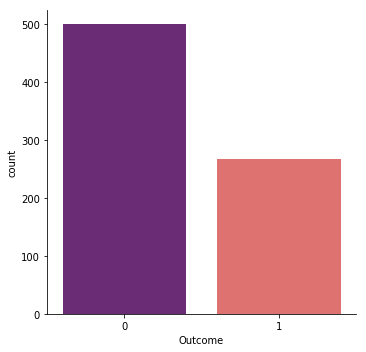

In [21]:
sns.catplot(x='Outcome', kind='count',
            data=df.toPandas(), palette='magma')

In [22]:
# Weighting for unequal sample size

dataset_size= float(train.select("Outcome").count())
num_positives= train.select("Outcome").where("Outcome == 1").count()
per_one = (float(num_positives)/dataset_size)

dataset_size, num_positives, per_one

print("The number of ones are %s" % num_positives)
print("Percentage of ones %s" % per_one)

The number of ones are 210
Percentage of ones 0.3387096774193548


In [23]:
num_negatives = dataset_size - num_positives
balance_ratio = num_negatives / dataset_size

print("balance_ration = %s" % balance_ratio)

balance_ration = 0.6612903225806451


In [24]:
train = train.withColumn("classWeights", when(train.Outcome == 1, balance_ratio).otherwise(1 - balance_ratio))
train.select("classWeights").show()

+-------------------+
|       classWeights|
+-------------------+
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
| 0.6612903225806451|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
|0.33870967741935487|
+-------------------+
only showing top 20 rows



In [25]:
#### Logistic regression



In [26]:
from pyspark.ml.classification import LogisticRegression

#Weighted columns
logit_model = LogisticRegression(labelCol='Outcome', featuresCol='features', weightCol='classWeights', maxIter=20)

In [27]:
# when training the algorithm always use training samples, don't apply to entire dataset
model = logit_model.fit(train)

In [28]:
predict_train = model.transform(train)
predict_test = model.transform(test)

In [29]:
predict_test.select("Outcome", "prediction").show()

+-------+----------+
|Outcome|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      1|       0.0|
|      0|       0.0|
|      1|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       1.0|
|      0|       0.0|
|      1|       1.0|
|      1|       1.0|
|      1|       1.0|
|      0|       0.0|
|      0|       0.0|
+-------+----------+
only showing top 20 rows



In [30]:
predict_test.where("Outcome == prediction").count(),\
predict_test.where("Outcome != prediction").count(),\
predict_test.where("Outcome == prediction").count()/predict_test.count(),

(114, 34, 0.7702702702702703)

In [31]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", 
                                             metricName="accuracy")

accuracy = evaluator.evaluate(predict_test)
print("Accuracy: ", (accuracy))

Accuracy:  0.7702702702702703


In [32]:
# Classification report
    # confusion matrix,
    # ROC curve (receiver operating characteristic curve),
    # F1-score

In [36]:
! pip3 install sklearn

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable


In [38]:
from sklearn.metrics import confusion_matrix

y_true = predict_test.select('Outcome').toPandas()
#y_true = y_true.toPandas()

y_pred = predict_test.select('prediction').toPandas()
#y_pred = y_pred.toPandas

confusion_mat = confusion_matrix(y_true, y_pred)
confusion_mat

array([[70, 20],
       [14, 44]])

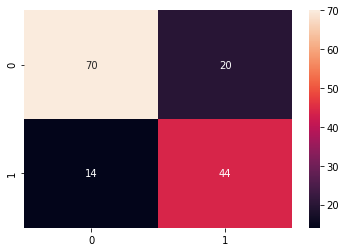

In [41]:
sns.heatmap(confusion_mat, annot=True)




In [ ]:
"""
           [actual]        [actual]
[predicted]           
           [true negative] [false negative]
[predicted]
           [false positive][true positive]

"""